In [2]:
import numpy as np
import pandas as pd
from pprint import pprint
import json
from typing import Dict, Optional, Text, Tuple, Union
from PIL import Image
from collections import defaultdict
import re

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs
from itertools import chain
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [7]:
!pip install openpyxl

     |████████████████████████████████| 243 kB 4.5 MB/s eta 0:00:01


In [2]:
def make_df_from_fixture(fixture_dict:dict):
    """convert a django format fixture into a pandas df """
    
    index = []
    fields = []
    for m in metadata:
        index.append(m["pk"])
        fields.append(m["fields"])

    col_names = m["fields"].keys()
    col_names = list(col_names)
    
    return pd.DataFrame(index=index, data=fields, columns=col_names)

In [3]:
def _take_along_axis(arr: tf.Tensor, indices: tf.Tensor) -> tf.Tensor:
    """Partial TF implementation of numpy.take_along_axis.
    See
    https://numpy.org/doc/stable/reference/generated/numpy.take_along_axis.html
    for details.
    Args:
    arr: 2D matrix of source values.
    indices: 2D matrix of indices.
    Returns:
    2D matrix of values selected from the input.
    """

    row_indices = tf.tile(
      tf.expand_dims(tf.range(tf.shape(indices)[0]), 1),
      [1, tf.shape(indices)[1]])
    gather_indices = tf.concat(
      [tf.reshape(row_indices, (-1, 1)),
       tf.reshape(indices, (-1, 1))], axis=1)

    return tf.reshape(tf.gather_nd(arr, gather_indices), tf.shape(indices))


# modified from tensorflow source code to prevent type error
def _exclude(scores: tf.Tensor, identifiers: tf.Tensor, exclude: tf.Tensor,
             k: int) -> Tuple[tf.Tensor, tf.Tensor]:
    """Removes a subset of candidates from top K candidates.
    For each row of inputs excludes those candidates whose identifiers match
    any of the identifiers present in the exclude matrix for that row.
    Args:
    scores: 2D matrix of candidate scores.
    identifiers: 2D matrix of candidate identifiers.
    exclude: 2D matrix of identifiers to exclude.
    k: Number of candidates to return.
    Returns:
    Tuple of (scores, indices) of candidates after exclusions.
    """

    idents = tf.expand_dims(identifiers, -1)
    exclude = tf.expand_dims(exclude, 1)

    isin = tf.math.reduce_any(tf.math.equal(idents, exclude), -1)

    # Set the scores of the excluded candidates to a very low value.
#     adjusted_scores = (scores - tf.cast(isin, tf.float32) * 1.0e5)
    
    ##### cast input scores to prevent type error
    adjusted_scores = (tf.cast(scores, tf.float64) - tf.cast(isin, tf.float64) * 1.0e5)

    k = tf.math.minimum(k, tf.shape(scores)[1])

    _, indices = tf.math.top_k(adjusted_scores, k=k)

    return _take_along_axis(scores,
                          indices), _take_along_axis(identifiers, indices)


def top_k_with_exclusions(topk, query, exclusions, k=100):
    """
    topk: instance of tensorflow TopK class
    query: vector to find similar records
    exclusions: ids of the records to exclude
    k: number of results to return
    """
    
    adjusted_k = k + exclusions.shape[1]
    x, y = topk.call(queries=query, k=adjusted_k)
    
    return _exclude(x, y, exclude=exclusions, k=k)

In [4]:
def make_class_record_dict(encoded_ser):
    """
    take a pd.Series where the index is the record id (that correlates to the id in the Retrieval model) and the values are the encoded classes as integers
    return a dictionary of sets
    """ 
    key_dict = {}
    for key in np.unique(encoded_ser):
#         print(key)
        fltr = encoded_ser == key
#         print(fltr.sum())
        key_dict[key] = set(encoded_ser[fltr].index)

    return key_dict

In [5]:
def flatten_series_of_lists(ser:pd.Series):
    """
    flatten a series of lists where the relationship between the index and the values 
    needs to be maintained
    ser: pd.Series where the values are lists
    """
    
    indices = []
    keys = []
    for index, row in ser.iteritems():
        if type(row) != list:
#          print(row)
            pass

        else:
            for key in row:
                indices.append(index)
                keys.append(key)

    return pd.Series(index=indices, data=keys, name=ser.name)

In [6]:
def create_class_dict(ser):
    
    # use a default dict to return -1 in case key is not found
    
    class_dict = defaultdict(lambda: -1)
    classes = np.unique(ser)
    indices = np.arange(len(classes))
    class_dict.update(dict(zip(classes, indices)))
    
    return classes, indices, class_dict


In [7]:
def split_and_flatten_series(ser, split_char=None):
    
    ser = ser.str.lower()
    # split into series of lists strings based split_char
    if split_char:
        ser = ser.str.split(split_char)
        # flatten series of lists
        ser = flatten_series_of_lists(ser)
    
    # strip whitespace from strings
    if ser.dtype == "O":
        ser = ser.str.strip()
    
    return ser

In [8]:
def series_to_class_record_dict(ser, split_char=None):
    """
    convert a comma separated string series of classes into a dictionary of encoded classes
    ser: pd.Series of strings
    split_char: string or None, character to split strings in the series by. e.g. ','
    returns: tuple of class_dict, class_record_dict
    
    example input:
    ser
    
    1000        Kaltnadel, Radierung
    1001    Japanpapier, Holzschnitt
    1002      Radierung, Kupferstich
    
    split_char
    ","
    
    example return
    (
     {'holzschnitt': 0,
      'japanpapier': 1,
      'kaltnadel': 2,
      'kupferstich': 3,
      'radierung': 4},
      
     {0: {1001}, 
      1: {1001}, 
      2: {1000}, 
      3: {1002},
      4: {1000, 1002}})
    
    """

    ser = split_and_flatten_series(ser, split_char=split_char)

    # create vocabulary dictionary
    classes, indices, class_dict = create_class_dict(ser)

    # encode the series
    ser_enco = ser.map(class_dict)
    
    # create set dictionary with the records per class
    class_record_dict = make_class_record_dict(ser_enco)
    
    return class_dict, class_record_dict
    

In [9]:
def get_record_ids_to_exclude_by_class(classes_to_keep:list, class_records_dict:dict, record_ids_set:set):
    """
    using sets get the records to exclude and include by filtering the relevant classes
    
    classes_to_keep:list of ints, the ids of the classes to included in the results
    class_records_dict: dict of format {class_id:set_of_record ids}
    record_ids_set: all of the potential records
    
    returns
    (records_to_exclude, records_to_include)
    """
    
    classes_to_keep = set(classes_to_keep)
    # make a set of the record ids to keep
    records_to_include = set()
    for class_id in classes_to_keep:
        records_to_include.update(class_records_dict[class_id])

    # remove the records that belong to the target classes that we want to keep
    # make a set of the record ids to remove
    records_to_exclude = record_ids_set.difference(records_to_include)

    return records_to_exclude, records_to_include

In [10]:
def map_record_ids_to_model_ids(df_feat):
    """using the calculated features csv
    create a map from record_indices to model_indices
    """
    
    df_fpath = df_feat.iloc[:,[0]]
    df_fpath = df_fpath.rename(columns={0:"fpath"})
    df_fpath['record_id'] = df_fpath["fpath"].str.rsplit(pat="/", n=1, expand=True)[1]
    df_fpath['record_id'] = df_fpath['record_id'].str.split(pat=".", n=1, expand=True)[0]
    map_record_id_model_id = dict(zip(df_fpath['record_id'].astype(int).to_list(), list(df_fpath.index)))
    
    return map_record_id_model_id, df_fpath

In [11]:
def get_record_ids_from_features_df(df_feat):
    """
    using the df from the calculated features csv
    add a column with record ids
    return df
    """
    
    df_fpath = df_feat.iloc[:,[0]]
    df_fpath = df_fpath.rename(columns={0:"fpath"})
    df_fpath['record_id'] = df_fpath["fpath"].str.rsplit(pat="/", n=1, expand=True)[1]
    df_fpath['record_id'] = df_fpath['record_id'].str.split(pat=".", n=1, expand=True)[0]
    df_fpath.index.rename("model_id", inplace=True)
    
    return df_fpath

In [12]:
def insert_min_max_years_into_df(df_meta, min_years, max_years, index):
    
    df_meta.loc[index,"min_year"] = min_years
    df_meta.loc[index,"max_year"] = max_years
    # convert from floats to pandas ints
    df_meta.loc[:,["min_year","max_year"]] = df_meta.loc[:,["min_year","max_year"]].astype("Int64")
    #fill in NaN's with -1 to still use numpy int comparisons
    fltr = df_meta[["min_year","max_year"]].isna().any(axis=1)
    df_meta.loc[fltr,["min_year","max_year"]] = -1
    
    return df_meta


In [13]:
def series_of_lists_to_array(ser, fill_value_index=None):
    """
    transform a series of lists (like returned by str.split()) into an array.
    By default, lists with differing lengths will be padded with None or
    fill_value_index can be used to select an element from each list to pad with.
    e.g. fill_value_index=-1 will pad the array to the right with the last element from each list 
    modified from https://stackoverflow.com/questions/10346336/list-of-lists-into-numpy-array
    
    """
    x=ser.values
    length=(np.vectorize(len)(x)).max()
    if fill_value_index==None:
        y=np.array([xi+[None]*(length-len(xi)) for xi in x])
    
    if type(fill_value_index)==int:
        y=np.array([xi+[xi[fill_value_index]]*(length-len(xi)) for xi in x])

    return y

In [14]:
def series_of_string_years_to_min_max_years(ser):
    """
    get min and max years from date column
    assumes the earliest and latest years (in digits) in the string
    are the earlist and latest years
    ser:pd.Series, date column from the metadata dataframe
    returns two pandas series: min_years, max_years
    """
#     ser_index = ser.index
    fltr = ser.isna()
    ser = ser.loc[~fltr]
    print("number of rows that were missing values: {:,}".format(fltr.sum()))
    # assumes that all years are after 99 A.D.
    ptrn = re.compile(r"[0-9]{3,4}")
    years = ser.apply(ptrn.findall)
    years = series_of_lists_to_array(years, fill_value_index=-1)
    years = years.astype(int)
    min_years = np.min(years, axis=1)
    max_years = np.max(years, axis=1)
    
    return min_years, max_years, ser.index

In [15]:
def insert_min_max_years_into_df(df_meta, min_years, max_years, index):
    
    df_meta.loc[index,"min_year"] = min_years
    df_meta.loc[index,"max_year"] = max_years
    # convert from floats to pandas ints
    df_meta.loc[:,["min_year","max_year"]] = df_meta.loc[:,["min_year","max_year"]].astype("Int64")
    #fill in NaN's with -1 to still use numpy int comparisons
    fltr = df_meta[["min_year","max_year"]].isna().any(axis=1)
    df_meta.loc[fltr,["min_year","max_year"]] = -1
    
    return df_meta


In [16]:
def get_record_ids_to_remove_by_year(years_arr, after_year=None, before_year=None):
    """
    years_arr: 2D numpy.array with earliest estimated year and latest estimated year. 
    after_year: results should be from this year or later
    before_year: results should be from this year or earlier
    
    returns
    year_ids_to_remove: set of ids that do not meet the filter criteria

    if before_year or after_year is within the range of the earliest estimated year and latest estimated year then
    the record will be included
    
    e.g. 
    """
    
    if after_year and before_year:
        assert after_year <= before_year, "after_year can't be less than before_year. after_year gets records from after or in this year. before_year gets records from before or in this year"

    fltr_after = True
    fltr_before = True

    # create year filters for values that meet the criteria
    if after_year:
        fltr_after = np.any(years_arr>=after_year, axis=1)

    if before_year:
        fltr_before = np.any(years_arr<=before_year, axis=1)

    # filter out NaNs (should be -1 in ther years_arr) keep in the results
    nan_fltr = years_arr[:,0]>=0
    # combine the three filters *must multiply in this order
    fltr_to_keep = nan_fltr & fltr_after & fltr_before
    
    # these are the indices to remove from the results
    indices_to_remove = np.where(~fltr_to_keep)
    
    return set(indices_to_remove[0]), fltr_to_keep

# Test with a sample of Graphische Sammlung Data 

# LOAD AND MERGE DATA

## Load extracted feature vectors from file

In [17]:
#fpath = "../data/processed/default/features.csv"
#fpath = "../data/processed/ethz/features_vgg16_imagenet.csv"
fpath = "../data/processed/ethz/trained/features_resnet50_trained.csv"
df_feat = pd.read_csv(fpath, header=None)
# fix file path due to difference in local setups
#df_feat[0] = df_feat[0].str.replace("../data/processed/","../data/processed/ethz/")

df_fpath = get_record_ids_from_features_df(df_feat)

#### Load a test image

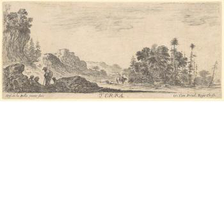

In [58]:
# check that the file paths are correct
img_fpth = df_fpath["fpath"][17186]
#img_fpth
Image.open(img_fpth)


## Load image metadata

In [19]:
# load metadata
#fpath = "../data/processed/ethz/fixtures/ImageMetadata.json"

#with open(fpath, "r") as f:
#    metadata = json.load(f)
fpath = "../data/raw/ethz/imageSearch_metadata_03.12.csv"
df_meta = pd.read_csv(fpath)
df_meta = df_meta.rename(columns={'recordID': 'record_id', 'matTec':'material_technique'})
#df_meta = make_df_from_fixture(metadata)
#df_meta.shape

In [20]:
df_meta.head()

,record_id,imageURL,invNr,person,date,title,classification,material_technique,institutionIsil,recordURL,imageLicence,timestamp
0,14943,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,1916.0047.1,"Vallotton, Félix (1865 - 1925), Künstler",Enstehung des Druckträgers: 1915,"La tranchée, Blatt Nr. 1 aus ""C'est la guerre""",Druckgraphik,Holzschnitt,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-06-25T20:22:59.957Z
1,17626,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,1916.0047.1-6,"Vallotton, Félix (1865 - 1925), Künstler, Hera...",Enstehung des Druckträgers: 1915 - 1916,C'est la guerre,Druckgraphik,Holzschnitt,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-06-25T20:45:41.43Z
2,12789,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,1916.0047.2,"Vallotton, Félix (1865 - 1925), Künstler",Enstehung des Druckträgers: 1915,"L'orgie, Blatt Nr. 2 aus ""C'est la guerre""",Druckgraphik,Holzschnitt,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-06-25T20:11:40.1Z
3,10098,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,1916.0047.3,"Vallotton, Félix (1865 - 1925), Künstler",Enstehung des Druckträgers: 1916,"Les fils de fer, Blatt Nr. 3 aus ""C'est la gue...",Druckgraphik,Holzschnitt,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-06-25T19:57:32.323Z
4,10829,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,1916.0047.4,"Vallotton, Félix (1865 - 1925), Künstler",Enstehung des Druckträgers: 1916,"Dans les ténèbres, Blatt Nr. 4 aus ""C'est la g...",Druckgraphik,Holzschnitt,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-06-25T20:01:25.563Z


In [20]:
df_meta.head()

,record_id,image_url,inventory_number,person,date,title,classification,material_technique,institution_isil,record_url,image_licence,created_date
1000,3,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 014392,Monogrammist IB [Nagler III 1950] (1523 - 1530...,Enstehung des Druckträgers: 1529,Marcus Curtius stürzt sich in die Erdspalte,Druckgraphik,"Papier vergé, Kupferstich",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
1001,11,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,Z 000326,"Ritz, Raphael (1829 - 1894), Künstler",Entstehung: 1850 - 1900 [zweite Hälfte des 19....,Champsec,Handzeichnung,Bleistift,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
1002,18,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 009945,"Franco, Battista (1510 um - 1561)",Enstehung des Druckträgers: Um 1525 - 1561,Philister bringen die Bundeslade in den Tempel...,Druckgraphik,"Kupferstich, dubliert, Radierung",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
1003,19,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 013409,"Sadeler (der Jüngere), Egidius (1570 um - 1629...",Enstehung des Druckträgers: 1607,Grosser Saal im Schloss in Prag [Linke Bildhäl...,Druckgraphik,Kupferstich,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
1004,33,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 011145,"Doo, George Thomas (1800 - 1886), Künstler; Wy...",Enstehung des Druckträgers: 1835,Schöne Försterin,Druckgraphik,"Kupferstich, Radierung",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00


In [21]:
# join metadata to fpaths and model ids
df_meta.index.rename("db_id", inplace=True)
df_meta = df_meta.reset_index()
df_meta["record_id"] = df_meta["record_id"].astype("Int64")
df_fpath["record_id"] = df_fpath["record_id"].astype(int)
df = df_fpath.merge(df_meta, how="left", on="record_id" )
df.index.rename("model_id", inplace=True)
df

,fpath,record_id,db_id,imageURL,invNr,person,date,title,classification,material_technique,institutionIsil,recordURL,imageLicence,timestamp
model_id,,,,,,,,,,,,,,
0,../data/processed/ethz/img_224*224/images/0/10...,107,5144.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 001367.23,"Raimondi, Marcantonio (1470 / 1482 um - um 152...",Enstehung des Druckträgers: 1510 - 1515,Veronika zwischen den Heiligen Petrus und Paul...,Druckgraphik,Kupferstich,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-10-07T14:58:23.207Z
1,../data/processed/ethz/img_224*224/images/0/11...,114,21251.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,Z 000324,"Ritz, Raphael (1829 - 1894), Künstler",Entstehung: 1850 - 1900 [zweite Hälfte des 19....,Prière en famille,Handzeichnung,Bleistift,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-02-22T15:05:47.441Z
2,../data/processed/ethz/img_224*224/images/0/11...,115,4995.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 013322,"Seifert, Friedrich (1838 - 1920); Pasqualoni, ...",Enstehung des Druckträgers: 1874,Messe von Bolsena,Druckgraphik,"Kupferstich, Chine collé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-06-25T17:50:47.553Z
3,../data/processed/ethz/img_224*224/images/0/12...,127,21256.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,Z 000329,"Ritz, Raphael (1829 - 1894), Künstler",Entstehung: Um 1850 - 19894,Chalets,Handzeichnung,"gehöht, Kreide",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-06-25T17:50:54.27Z
4,../data/processed/ethz/img_224*224/images/0/12...,128,4813.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 013075,"Jegher, Christoffel (1596 vor - um 1653), Ausf...",Enstehung des Druckträgers: 1633 - 1636,Ruhe auf der Flucht nach Ägypten,Druckgraphik,"Holzschnitt, Chiaroscuroschnitt",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-10-20T08:04:26.363Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20830,../data/processed/ethz/img_224*224/images/21/2...,21104,15457.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 005468,"Dyck, Anton van (1599 - 1641), Vorlage; Clouwe...",Enstehung des Druckträgers: 1640 - 1650,Porträt von Theodoor Rogiers [Rasier; de Rasiè...,Druckgraphik,Kupferstich,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-06-25T21:22:34.603Z
20831,../data/processed/ethz/img_224*224/images/21/2...,21107,18318.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 007624,"Meckenem, Israhel van (1440 / 1445 um - 1503),...",Enstehung des Druckträgers: Um 1500 - 1503,Tod der Lucretia,Druckgraphik,Kupferstich,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-09-16T12:38:45.637Z
20832,../data/processed/ethz/img_224*224/images/21/2...,21108,14999.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 005052,"Rembrandt Harmensz. van Rijn (1606 - 1669), Kü...",Enstehung des Druckträgers: Um 1644,"Ruhe auf der Flucht nach Ägypten, Nachtstück",Druckgraphik,"Kaltnadel, Radierung",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-10-16T13:38:11.137Z


In [22]:
df

,fpath,record_id,db_id,image_url,inventory_number,person,date,title,classification,material_technique,institution_isil,record_url,image_licence,created_date
model_id,,,,,,,,,,,,,,
0,../data/processed/ethz/images/135/135484.png,135484,16264.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018045,"Bella, Stefano della (1610 - 1664), Künstler",Enstehung des Druckträgers: 1646 / 1647,Erde,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
1,../data/processed/ethz/images/135/135485.png,135485,16265.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018046,"Bella, Stefano della (1610 - 1664), Künstler",Enstehung des Druckträgers: 1646 / 1647,Luft,Druckgraphik,"Radierung, Papier vergé, dubliert",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
2,../data/processed/ethz/images/135/135487.png,135487,16266.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018047,"Bella, Stefano della (1610 - 1664), Künstler",Enstehung des Druckträgers: 1646 / 1647,Feuer,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
3,../data/processed/ethz/images/135/135483.png,135483,16263.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018044,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1638 - 1644,Seegefecht,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
4,../data/processed/ethz/images/95/95505.png,95505,15738.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 017580.10,"Tempesta, Antonio (1555 - 1630), Künstler; Ael...",Enstehung des Druckträgers: 1613,"Israeliter bekämpfen die Amalekiter, Blatt 9 d...",Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20830,../data/processed/ethz/images/25/25618.png,25618,8779.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 006612,"Wyngaerde, Frans van den (1614 - 1679), Ausfüh...",Enstehung des Druckträgers: 1626 - 1679,"Nacht, Blatt 4 der Folge ""Vier Tageszeiten""",Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
20831,../data/processed/ethz/images/25/25142.png,25142,8376.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 007358,"Both, Andries (1612 / 1613 - 1642)",Enstehung des Druckträgers: 1622 - 1642,"Betender Eremit, nach links",Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00
20832,../data/processed/ethz/images/25/25624.png,25624,8784.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 011334,"Pontius, Paulus (1603 - 1658); Jordaens, Jacob...",Enstehung des Druckträgers: 1620 - 1658,Flucht nach Ägypten,Druckgraphik,Kupferstich,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00


# ######## 

### extract years from dates columm

In [22]:
# process dates
ser = df["date"].dropna()
min_years, max_years, index = series_of_string_years_to_min_max_years(ser)
df = insert_min_max_years_into_df(df, min_years, max_years, index)

number of rows that were missing values: 0


In [23]:
df

,fpath,record_id,db_id,imageURL,invNr,person,date,title,classification,material_technique,institutionIsil,recordURL,imageLicence,timestamp,min_year,max_year
model_id,,,,,,,,,,,,,,,,
0,../data/processed/ethz/img_224*224/images/0/10...,107,5144.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 001367.23,"Raimondi, Marcantonio (1470 / 1482 um - um 152...",Enstehung des Druckträgers: 1510 - 1515,Veronika zwischen den Heiligen Petrus und Paul...,Druckgraphik,Kupferstich,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-10-07T14:58:23.207Z,1510,1515
1,../data/processed/ethz/img_224*224/images/0/11...,114,21251.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,Z 000324,"Ritz, Raphael (1829 - 1894), Künstler",Entstehung: 1850 - 1900 [zweite Hälfte des 19....,Prière en famille,Handzeichnung,Bleistift,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-02-22T15:05:47.441Z,1850,1900
2,../data/processed/ethz/img_224*224/images/0/11...,115,4995.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 013322,"Seifert, Friedrich (1838 - 1920); Pasqualoni, ...",Enstehung des Druckträgers: 1874,Messe von Bolsena,Druckgraphik,"Kupferstich, Chine collé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-06-25T17:50:47.553Z,1874,1874
3,../data/processed/ethz/img_224*224/images/0/12...,127,21256.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,Z 000329,"Ritz, Raphael (1829 - 1894), Künstler",Entstehung: Um 1850 - 19894,Chalets,Handzeichnung,"gehöht, Kreide",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-06-25T17:50:54.27Z,1850,1989
4,../data/processed/ethz/img_224*224/images/0/12...,128,4813.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 013075,"Jegher, Christoffel (1596 vor - um 1653), Ausf...",Enstehung des Druckträgers: 1633 - 1636,Ruhe auf der Flucht nach Ägypten,Druckgraphik,"Holzschnitt, Chiaroscuroschnitt",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-10-20T08:04:26.363Z,1633,1636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20830,../data/processed/ethz/img_224*224/images/21/2...,21104,15457.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 005468,"Dyck, Anton van (1599 - 1641), Vorlage; Clouwe...",Enstehung des Druckträgers: 1640 - 1650,Porträt von Theodoor Rogiers [Rasier; de Rasiè...,Druckgraphik,Kupferstich,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-06-25T21:22:34.603Z,1640,1650
20831,../data/processed/ethz/img_224*224/images/21/2...,21107,18318.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 007624,"Meckenem, Israhel van (1440 / 1445 um - 1503),...",Enstehung des Druckträgers: Um 1500 - 1503,Tod der Lucretia,Druckgraphik,Kupferstich,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-09-16T12:38:45.637Z,1500,1503
20832,../data/processed/ethz/img_224*224/images/21/2...,21108,14999.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 005052,"Rembrandt Harmensz. van Rijn (1606 - 1669), Kü...",Enstehung des Druckträgers: Um 1644,"Ruhe auf der Flucht nach Ägypten, Nachtstück",Druckgraphik,"Kaltnadel, Radierung",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-10-16T13:38:11.137Z,1644,1644


In [24]:
# many records contain the word "um" meaning around
# the majority of these records already include a range of dates
# so for now, "um" records will not be modified any further
tser = ser.dropna()
tser.loc[tser.str.contains("um")].head(30)

model_id
3216    Enstehung des Druckträgers: 1690 - 1710 [um 1700]
3524    Enstehung des Druckträgers: Um 1490 - 1510 [um...
3773                    Entstehung: 1790 - 1810 [um 1800]
3991    Enstehung des Druckträgers: 1690 - 1710 [um 1700]
3993    Enstehung des Druckträgers: 1690 - 1710 [um 1700]
3995    Enstehung des Druckträgers: 1690 - 1710 [um 1700]
4000    Enstehung des Druckträgers: 1690 - 1710 [um 17...
4001    Enstehung des Druckträgers: 1690 - 1710 [um 17...
4526    Enstehung des Druckträgers: 1690 - 1710 [um 17...
4527    Enstehung des Druckträgers: 1690 - 1710 [um 17...
4528    Enstehung des Druckträgers: 1690 - 1710 [um 17...
4529    Enstehung des Druckträgers: 1690 - 1710 [um 17...
4666    Enstehung des Druckträgers: 1690 - 1710 [um 17...
4667    Enstehung des Druckträgers: 1690 - 1710 [um 17...
4668    Enstehung des Druckträgers: 1690 - 1710 [um 17...
4669    Enstehung des Druckträgers: 1690 - 1710 [um 17...
4670    Enstehung des Druckträgers: 1690 - 1710 [um 17...
4671 


years_arr = df[["min_year","max_year"]].values
#after_year: get records from after or in this year
after_year = None
#before_year: get records from before or in this year
before_year = 1600
year_ids_to_remove, fltr_to_keep = get_record_ids_to_remove_by_year(years_arr, after_year=after_year, before_year=before_year)
print("date filter to remove {:,} records ({:.2%})".format(len(year_ids_to_remove), (len(year_ids_to_remove)/years_arr.shape[0])))

# ############################

# process a feature column
ser = df_meta.loc[:,"material_technique"].dropna()
record_ids_set = set(ser.index)

mat_tec_class_dict, mat_tec_records_dict = series_to_class_record_dict(ser, split_char=",")
mat_tec_label_lookup = dict(zip(mat_tec_class_dict.values(), mat_tec_class_dict.keys()))

# process a feature column
ser = df_meta.loc[:,"person"].dropna()
person_class_dict, person_records_dict = series_to_class_record_dict(ser, split_char=";")

print(mat_tec_class_dict['kupferstich'])

# process a feature column
ser = df_meta.loc[:,"classification"].dropna(how='any')
classification_class_dict, classification_records_dict = series_to_class_record_dict(ser, split_char=None)

# radierung should be found!!!!
materials_class_dict["radierung"]

# for k in materials_class_dict.keys():
#     print(f"|{k}|")

mat_tec_classes_to_keep = ["dubliert",'lithographie']

# look up id of each class
mat_tec_class_ids_to_keep= [mat_tec_class_dict[cls_name] for cls_name in classes_to_keep]
mat_tec_ids_to_exclude=set()
mat_tec_ids_to_exclude, mat_tec_ids_to_include = get_record_ids_to_exclude_by_class(classes_to_keep, mat_tec_records_dict, record_ids_set)

for class_id in classes_to_keep:
    print(class_id, " : ", mat_tec_label_lookup[class_id])
    
print("records_to_include: ", len(mat_tec_ids_to_include))
print("records_to_exclude: ", len(mat_tec_records_to_exclude))


sets_to_exclude = [year_ids_to_exclude, mat_tec_ids_to_exclude]
ids_to_exclude = set().union(*sets_to_exclude)

for ls in [year_ids_to_exclude, mat_tec_ids_to_exclude]:
    print(len(ls))


len(ids_to_exclude)

y_arr = np.array([[10,19],
                 [20,29],
                 [30,39],
                 [40,45],
                 [-1,-1]])
after_year=21
before_year=39
year_ids_to_exclude, fltr_to_keep = get_record_ids_to_remove_by_year(y_arr, 
                                                                      after_year=after_year, 
                                                                      before_year=before_year)
year_ids_to_exclude

fltr_after = np.any(y_arr>=after_year, axis=1)
fltr_after

fltr_before = np.any(y_arr<=before_year, axis=1)
fltr_before = np.any(y_arr<=before_year, axis=1)
fltr_before

fltr_nan = np.any(y_arr>0)

fltr_before & fltr_after

f = fltr_before & fltr_after & fltr_nan
f

np.where(~(fltr_before & fltr_after))



### MAIN Query Function

In [25]:
# main_arg input df_meta

# create lookup objects
record_ids_set = set(df.index)
years_arr = df[["min_year","max_year"]].values

ser = df.loc[:,"material_technique"].dropna()
mat_tec_class_dict, mat_tec_records_dict = series_to_class_record_dict(ser, split_char=",")

In [26]:
#query args
#after_year: get records from after or in this year
after_year = 1645
#before_year: get records from before or in this year
before_year = 1650
# material techniques
# mat_tec_classes_to_keep = ["dubliert",'lithographie']
# mat_tec_classes_to_keep = ["radierung"]
mat_tec_classes_to_keep=[]


In [27]:
# initialise sets to exclude as empty sets overwrite if there are query args for that feature)
year_ids_to_exclude = set()
mat_tec_ids_to_exclude = set()

if after_year or before_year:
    year_ids_to_exclude, fltr_to_keep = get_record_ids_to_remove_by_year(years_arr, 
                                                                          after_year=after_year, 
                                                                          before_year=before_year)

if mat_tec_classes_to_keep:
    # look up date class ids form string names
    mat_tec_class_ids_to_keep= [mat_tec_class_dict[cls_name] for cls_name in mat_tec_classes_to_keep]
    mat_tec_ids_to_exclude, mat_tec_ids_to_include = get_record_ids_to_exclude_by_class(mat_tec_class_ids_to_keep, 
                                                                                      mat_tec_records_dict, 
                                                                                      record_ids_set)

# combine sets of ids to exclude
sets_to_exclude = [year_ids_to_exclude, mat_tec_ids_to_exclude]
ids_to_exclude = set().union(*sets_to_exclude)   

# return ids_to_exclude

In [28]:
len(ids_to_exclude)

17075

In [29]:
ids_to_include = record_ids_set.difference(ids_to_exclude)
ids_to_include = np.sort(list(ids_to_include))[:10]
ids_to_include

array([ 11,  95, 120, 128, 129, 136, 150, 164, 197, 200])

In [30]:
df.loc[ids_to_include,:]

,fpath,record_id,db_id,imageURL,invNr,person,date,title,classification,material_technique,institutionIsil,recordURL,imageLicence,timestamp,min_year,max_year
model_id,,,,,,,,,,,,,,,,
11,../data/processed/ethz/img_224*224/images/0/17...,172,21108.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 009930,"Falconetto, Angelo (1507 - 1567)",Enstehung des Druckträgers: Um 1635 - 1696,"Jungfrau Maria mit der Heiligen Elisabeth, Jes...",Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-06-25T17:51:24.177Z,1635,1696
95,../data/processed/ethz/img_224*224/images/0/61...,610,17971.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 007324,"Bronchorst, Jan Gerritsz. van (1603 um - 1661)",Enstehung des Druckträgers: 1650,"Porträt von Mathias de Merwede, Seigneur de Cl...",Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-08-27T16:38:15.807Z,1650,1650
120,../data/processed/ethz/img_224*224/images/0/95...,95,4821.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 013084,"Visscher II, Cornelis (1629 um - 1658), Ausfüh...",Enstehung des Druckträgers: 1644 - 1650,Jüngstes Gericht,Druckgraphik,Kupferstich,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-10-23T10:29:34.407Z,1644,1650
128,../data/processed/ethz/img_224*224/images/0/96...,965,3909.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 012174,"Morin, Jean (1600 um - 1650); Fouquier, Jacque...",Enstehung des Druckträgers: 1625 - 1651,Landschaft mit Reiter,Druckgraphik,"Radierung, Roulette",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-03-03T10:07:38.709Z,1625,1651
129,../data/processed/ethz/img_224*224/images/0/96...,969,3914.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 012179,"Plattenberg, Nicolas van (1631 - 1706); Champa...",Enstehung des Druckträgers: Vor 1650,Schweisstuch der Veronika,Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-03-03T10:07:38.709Z,1650,1650
136,../data/processed/ethz/img_224*224/images/0/31...,312,3910.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 012175,"Morin, Jean (1600 um - 1650); Fouquier, Jacque...",Enstehung des Druckträgers: 1625 - 1651,Landschaft mit Feldarbeitern bei der Pause,Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-03-03T10:07:38.709Z,1625,1651
150,../data/processed/ethz/img_224*224/images/0/39...,398,3185.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 011537,"Eillarts, Johannes (1612 erwähnt um); Feddes, ...",Enstehung des Druckträgers: 1612 - 1650,"Porträt von Albert [Albrecht VII.], Erzherzog ...",Druckgraphik,Kupferstich,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-06-25T17:53:54.73Z,1612,1650
164,../data/processed/ethz/img_224*224/images/0/47...,470,3834.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 012105,"Cortese, Guglielmo (1628 - 1679)",Enstehung des Druckträgers: 1650 - 1660,Pest oder die Bestattung der Toten,Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-06-25T17:54:53.017Z,1650,1660
197,../data/processed/ethz/img_224*224/images/1/15...,1595,4942.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 013224,"Saraceni, Girolamo (1588 - 1649)",Enstehung des Druckträgers: 1647,Ansicht der Villa Farnesina,Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-06-25T18:10:04.387Z,1647,1647


In [37]:
df[df['fpath'].str.contains("135484.png")]

,fpath,record_id,db_id,imageURL,invNr,person,date,title,classification,material_technique,institutionIsil,recordURL,imageLicence,timestamp,min_year,max_year
model_id,,,,,,,,,,,,,,,,
17186,../data/processed/ethz/img_224*224/images/135/...,135484,8559.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018045,"Bella, Stefano della (1610 - 1664), Künstler",Enstehung des Druckträgers: 1646 / 1647,Erde,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-10-13T09:40:54.317Z,1646,1647


#### Use topk Layer

In [31]:
# init the topk layer
topk = tfrs.layers.factorized_top_k.BruteForce(k=100)
# create the index for the topk NN model
# get the features array
img_features = df_feat.iloc[:,1:].values
#create the index
topk = topk.index(img_features)


2021-08-24 17:03:40.866455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-24 17:03:40.909388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-24 17:03:40.910196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-24 17:03:40.911868: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [32]:
img_features[0,:].shape

(1024,)

In [38]:
model_id = 17186
query_1 = tf.constant(img_features[model_id,:].reshape(1,-1), dtype=np.float64)
exclusions=tf.constant([list(ids_to_exclude)])
k=10

## Query WITHOUT exclusions 

In [39]:
# for testing purposes
# first query without exclusions
scores, result_ids = topk.call(query_1, k=k)
result_ids_arr = np.sort(result_ids[0])
result_ids_arr
#get metadata for from tensor of result ids
df.loc[result_ids.numpy()[0].tolist(),:]

,fpath,record_id,db_id,imageURL,invNr,person,date,title,classification,material_technique,institutionIsil,recordURL,imageLicence,timestamp,min_year,max_year
model_id,,,,,,,,,,,,,,,,
17186,../data/processed/ethz/img_224*224/images/135/...,135484,8559.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018045,"Bella, Stefano della (1610 - 1664), Künstler",Enstehung des Druckträgers: 1646 / 1647,Erde,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-10-13T09:40:54.317Z,1646,1647
8352,../data/processed/ethz/img_224*224/images/26/2...,26119,1365.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 010156.1,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1645 - 1647,"Terra (Erde), Blatt 1 der Folge ""Die vier Elem...",Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-10-13T13:37:14.947Z,1645,1647
10036,../data/processed/ethz/img_224*224/images/28/2...,28840,1366.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 010156.1-4,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1645 - 1647,Vier Elemente,Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-03-03T10:07:27.199Z,1645,1647
10998,../data/processed/ethz/img_224*224/images/29/2...,29718,1756.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 010422.2,"Callot, Jacques (1592 - 1635)",Enstehung des Druckträgers: Um 1618 - 1624,"Taubenschlag, Blatt 2 der Folge ""Die vier Land...",Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-06-25T23:55:36.81Z,1618,1624
14253,../data/processed/ethz/img_224*224/images/34/3...,34420,8506.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 001801,"Lory, Gabriel (genannt Lory père) (1763 - 1840...",Enstehung des Druckträgers: 1792,Vue des Environs de Lausanne,Druckgraphik,"handkoloriert, Radierung",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-06-26T01:27:59.08Z,1792,1792
2429,../data/processed/ethz/img_224*224/images/225/...,225926,10549.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 020957,"Anonym (Datierung unbekannt), Künstler/in; Rog...",Enstehung des Druckträgers: Um 1650 [?],Landschaft mit Dorf und Burg,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-09-10T13:18:18.823Z,1650,1650
2990,../data/processed/ethz/img_224*224/images/227/...,227694,10913.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 021251,"Swanevelt, Herman van (1600 um - um 1655), Kün...",Enstehung des Druckträgers: Um 1620 - 1655,Landschaft mit Sonnenaufgang,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2020-09-10T13:18:57.72Z,1620,1655
5870,../data/processed/ethz/img_224*224/images/242/...,242555,12751.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 023938,"Silvestre, Israël (1621 - 1691), Künstler; Swa...",Enstehung des Druckträgers: Um 1640 - 1655,Ansicht der Insel St. Louis in Paris,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-01-28T13:37:56.348Z,1640,1655
2218,../data/processed/ethz/img_224*224/images/224/...,224601,10456.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 020597,"Almeloveen, Jan van (1652 um - 1683), Künstler",Enstehung des Druckträgers: Um 1670 - 1683,Landschaft mit Fluss,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e

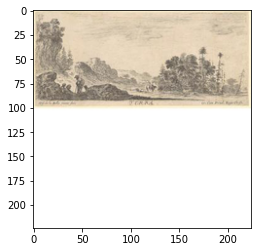

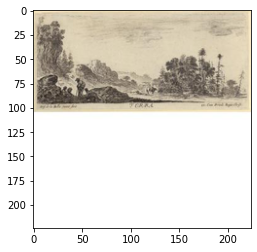

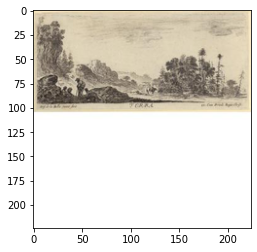

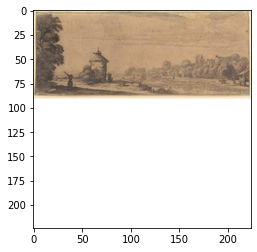

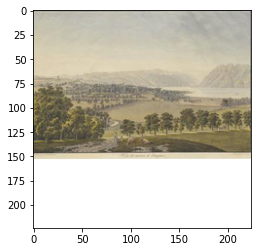

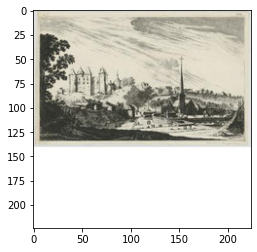

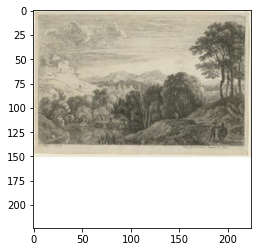

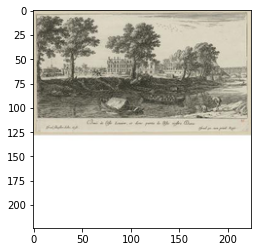

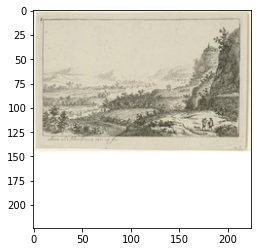

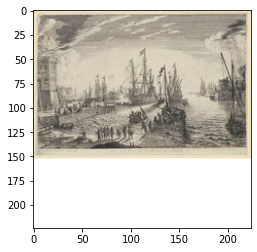

In [66]:
results = df.loc[result_ids.numpy()[0].tolist(),:]

for index in range(results.shape[0]):
    path = results.iloc[index,0]
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()
    #Image.open(path)
    #print(results['fpath'][index])
#    print(index)
#for result in results[['fpath']]:
#    print(result)

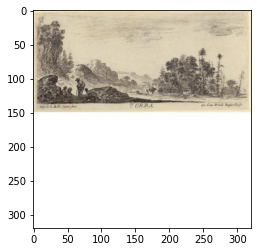

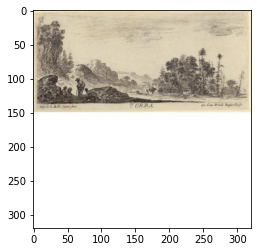

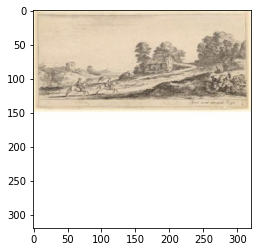

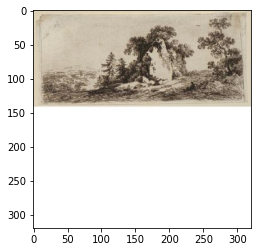

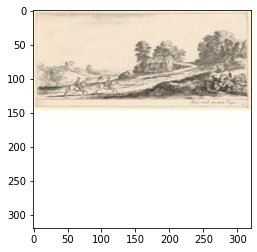

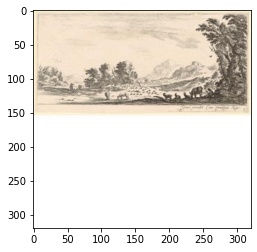

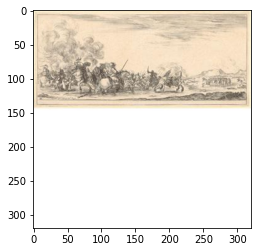

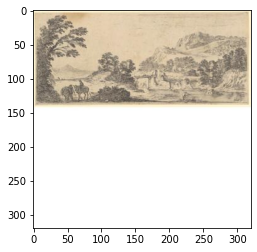

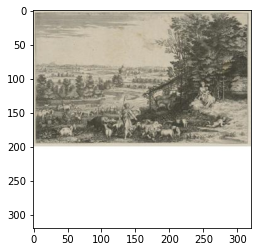

In [68]:
vgg_results = ['../data/processed/ethz/images/28/28840.png','../data/processed/ethz/images/26/26119.png','../data/processed/ethz/images/137/137483.png','../data/processed/ethz/images/27/27747.png','../data/processed/ethz/images/137/137485.png','../data/processed/ethz/images/137/137486.png','../data/processed/ethz/images/130/130485.png','../data/processed/ethz/images/134/134527.png','../data/processed/ethz/images/237/237498.png'] 
for result in vgg_results:
    img = mpimg.imread(result)
    imgplot = plt.imshow(img)
    plt.show()

In [54]:
#get metadata for from tensor of result ids
df.loc[result_ids.numpy()[0].tolist(),:]

,fpath,record_id,db_id,image_url,inventory_number,person,date,title,classification,material_technique,institution_isil,record_url,image_licence,created_date,min_year,max_year
model_id,,,,,,,,,,,,,,,,
0,../data/processed/ethz/images/135/135484.png,135484,16264.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018045,"Bella, Stefano della (1610 - 1664), Künstler",Enstehung des Druckträgers: 1646 / 1647,Erde,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00,1646,1647
9151,../data/processed/ethz/images/28/28840.png,28840,11444.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 010156.1-4,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1645 - 1647,Vier Elemente,Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00,1645,1647
9960,../data/processed/ethz/images/26/26119.png,26119,9194.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 010156.1,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1645 - 1647,"Terra (Erde), Blatt 1 der Folge ""Die vier Elem...",Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00,1645,1647
13626,../data/processed/ethz/images/137/137483.png,137483,16279.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018060,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1643 / 1646,Zwei nach rechts galoppierende Reiter,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00,1643,1646
5752,../data/processed/ethz/images/27/27747.png,27747,10543.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 009549,"Goethe, Johann Wolfgang von (1749 - 1832)",Enstehung des Druckträgers: 1754 - 1832,Landschaft mit Findling,Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00,1754,1832
13633,../data/processed/ethz/images/137/137485.png,137485,16281.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018061,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1643 / 1646,Zwei nach rechts galoppierende Reiter,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00,1643,1646
13662,../data/processed/ethz/images/130/130485.png,130485,16182.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 017984,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: Um 1642,Reitergefecht,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00,1642,1642
13630,../data/processed/ethz/images/137/137486.png,137486,16282.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018063,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1643 / 1646,Schäferin auf einer Weide mit Viehherde,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00,1643,1646
999,../data/processed/ethz/images/134/134527.png,134527,16262.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018043,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1638 - 1644,Flusslandschaft mit Steinbrücke,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?se

In [8]:
fpath = "../data/raw/ethz/imageSearch_relations.xlsx"
df_rel = pd.read_excel(fpath)
df_rel[df_rel['recordID'] == 135484]

,recordID,imageURL,invNr,person,date,title,classification,matTec,institutionIsil,recordURL,imageLicence,relations,timestamp
1159,135484,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018045,"Bella, Stefano della (1610 - 1664), Künstler",Enstehung des Druckträgers: 1646 / 1647,Erde,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,"Abzug, D 010156.1",2020-10-13T09:40:54.317Z


#### query WITH exclusions

In [55]:
# then query WITH exclusions
scores, result_ids = top_k_with_exclusions(topk, query_1, exclusions, k)

In [56]:
result_ids_arr = np.sort(result_ids)[0]
result_ids_arr

array([    0,  2264,  9151,  9960, 12610, 12614, 13626, 13630, 13633,
       14873], dtype=int32)

In [57]:
np.sort(list(ids_to_exclude))

array([    3,     4,     5, ..., 20829, 20831, 20834])

In [58]:
ids_to_exclude.intersection(set(list(result_ids_arr)))

set()

In [59]:
#get metadata for from tensor of result ids
df.loc[result_ids_arr,:]

,fpath,record_id,db_id,image_url,inventory_number,person,date,title,classification,material_technique,institution_isil,record_url,image_licence,created_date,min_year,max_year
model_id,,,,,,,,,,,,,,,,
0,../data/processed/ethz/images/135/135484.png,135484,16264.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018045,"Bella, Stefano della (1610 - 1664), Künstler",Enstehung des Druckträgers: 1646 / 1647,Erde,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00,1646,1647
2264,../data/processed/ethz/images/227/227948.png,227948,18971.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 021471,"Anonym (Datierung unbekannt), Künstler/in; Vel...",Enstehung des Druckträgers: 1634 - 1666 [zweit...,Turmruine an einem Fluss mit zwei Kühen im Vor...,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00,1634,1666
9151,../data/processed/ethz/images/28/28840.png,28840,11444.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 010156.1-4,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1645 - 1647,Vier Elemente,Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00,1645,1647
9960,../data/processed/ethz/images/26/26119.png,26119,9194.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 010156.1,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1645 - 1647,"Terra (Erde), Blatt 1 der Folge ""Die vier Elem...",Druckgraphik,Radierung,Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00,1645,1647
12610,../data/processed/ethz/images/136/136490.png,136490,16274.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018054,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1643 / 1646,"Zwei Pilger vor einer Ruine, im Hintergrund ei...",Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00,1643,1646
12614,../data/processed/ethz/images/136/136487.png,136487,16271.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018053,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1643 / 1646,"Zwei Pilger vor einer Ruine, im Hintergrund ei...",Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00,1643,1646
13626,../data/processed/ethz/images/137/137483.png,137483,16279.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018060,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1643 / 1646,Zwei nach rechts galoppierende Reiter,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00,1643,1646
13630,../data/processed/ethz/images/137/137486.png,137486,16282.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018063,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1643 / 1646,Schäferin auf einer Weide mit Viehherde,Druckgraphik,"Radierung, Papier vergé",Graphische Sammlung ETH Zürich (CH-000511-9),https://e-gs.ethz.ch/eMP/eMuseumPlus?service=E...,Public Domain Mark 1.0,2021-08-12T13:54:34+01:00,1643,1646
13633,../data/processed/ethz/images/137/137485.png,137485,16281.0,https://e-gs.ethz.ch/eMP/eMuseumPlus?service=I...,D 018061,"Bella, Stefano della (1610 - 1664), Künstler; ...",Enstehung des Druckträgers: 1643 / 1646,Zwei nach rechts galoppierende Rei

# Timeit

```python
%%timeit
df_meta.index.unique()
```
<hr>
> 60.9 µs ± 8.41 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

```python
%%timeit
set(df_meta.index)
```
<hr/>
> 8.2 µs ± 1.47 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)

```python
%%timeit
np.unique(df_meta.index)
```
<hr/>
> 17.5 µs ± 1.49 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)

```python
%%timeit
record_ids = set(df_meta.index)
```
<hr>
5.19 µs ± 175 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

### tf one_hot to sklearn OneHotEncoder**

```python
%%timeit
oneEnc = OneHotEncoder()
oneEnc.fit_(mat_tec_ser.values.reshape(-1, 1))
mat_tec_one_hot = oneEnc.transform(mat_tec_ser.values.reshape(-1, 1)).toarray()
```
=> 349 µs ± 14 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

```python
%%timeit
mat_tec_one_hot = tf.one_hot(mat_tec_ser.values, len(mat_tecs_indices))
```
=> 49.5 µs ± 1.86 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

#### accessing values from a series vs tolist
```python
%%timeit
dates.values
```
<hr>
417 ns ± 45.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


```python
%%timeit
dates.tolist()
```
<hr>
1.1 µs ± 14 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)

### Set timing comparisons 

```python

%%timeit
keys_to_exclude = keys_to_keep.difference(set(mat_tecs_indices))
```
<hr>
4.68 µs ± 412 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


```python
%%timeit
keys_to_exclude= [k for k in mat_tecs_indices if k not in keys_to_keep]
```
<hr>
9.26 µs ± 1.24 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)

```python
%%timeit
records_to_exclude = []
for k in keys_to_exclude:
    records_to_exclude.extend(mat_tec_dict[k])
records_to_exclude = set(records_to_exclude)
```
<hr>
> 10.3 µs ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)

```python
%%timeit
records_to_exclude = set()
for k in keys_to_exclude:
    records_to_exclude.update(mat_tec_dict[k])
```
<hr>
> 7.01 µs ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)

```python
%%timeit
mat_tec_ids_to_exclude.union(year_ids_to_exclude)
```
<hr>

2.28 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

```python
%%timeit
mat_tec_ids_to_exclude | year_ids_to_exclude
```
<hr>
3.22 ms ± 421 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

```python
set_list = [set(np.arange(i,i+1000)) for i in np.arange(start=0,stop=1000000,step=1000)]
len(set_list)
```
<hr>
1000

```python
%%timeit
full_set = set()
for set_i in set_list:
    full_set.update(set_i)
```
<hr>
35.7 ms ± 3.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

```python
%%timeit
full_set = set.union(*set_list)
```
<hr>
32.9 ms ± 3.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)